# SIR Model for COVID-19

COVID-19 has put all our lives at  a stand still. It has infected more than 2.9 million people around the world, out of which approximately 206,728 people lost their lives to this disease. 

We have used the SIR model to forecast the transmission rate of this deadly disease. This model puts everyone in one of the three categories: Susceptible, Infected or Resistant. In the initial timestep, all the patients will fall into the infected category and everyone else is susceptible. 

In [130]:
# Install jax, and numpyro
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from jax.experimental.ode import build_odeint
import jax.numpy as np
import jax.random as random
from jax.random import PRNGKey

import numpy as onp
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import handlers

from jax import vmap
import datetime

from IPython.display import display, Markdown
import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

![Image](../img/sir.jpeg)

$$\texttt{SIR Model}$$

As we progress over time, some of the susceptible people become infected and some of the infected people become resistant. We assume that the resistant cannot be affected by  the disease again.
We have assumed a constant population size and those who have unfortunately died are put into the resistant category, since they cannot spread the virus. 



When the infected population increases, more susceptible people will contract the disease. At this point, there will be an exponential increase in the number of cases as we can see in the graph below.  After a point, there will be many recovered cases that the number of susceptible people meeting the infected decreases.

![Image](../img/sir_graph.jpeg)

$$\texttt{Variation in S, I, R with time}$$

## Loading the data 

In [46]:
pop_data_ecdc = pd.read_csv(
    "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
)


def get_country_pop(country_geoID):
    pop = pop_data_ecdc[pop_data_ecdc.geoId == country_geoID].popData2018
    pop = pop.to_numpy()[0]
    return pop

In [47]:
pop_data_ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,25/04/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
1,24/04/2020,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia
2,23/04/2020,23,4,2020,84,4,Afghanistan,AF,AFG,37172386.0,Asia
3,22/04/2020,22,4,2020,61,1,Afghanistan,AF,AFG,37172386.0,Asia
4,21/04/2020,21,4,2020,35,2,Afghanistan,AF,AFG,37172386.0,Asia


## Exploratory Data Analysis

The URL's pertaining to the data of confirmed, recovered and deaths across countries due to COVID19 is stored and then the data is read from the respective URL's to store it in three different CSV file's.

In [50]:
# Storing the url's
confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
url = {"confirmed": confirmed_url,
       "deaths": deaths_url,
       "recovered": recovered_url}

2:80: E501 line too long (168 > 79 characters)
3:80: E501 line too long (162 > 79 characters)
4:80: E501 line too long (168 > 79 characters)


In [51]:
idata = pd.read_csv(confirmed_url)
ddata = pd.read_csv(deaths_url)
rdata = pd.read_csv(recovered_url)

The tidy_data function takes in a csv data and type of compartment which is either confirmed, recovered, deaths due to COVID-19 and outputs a tidy dataframe, which has country, date, cumulative cases(either confirmed, recovered, deaths depending on the type of data provided), new cases, days since the first confirmed case was observed. This tidy dataframe is used for exploratory data analysis.

In [133]:
def tidy_data(data, compartment):
    """
  Input: data, compartment:(confirmed/recovered/deaths)
  Output: Tidy data with cols as country, date, cases, new_cases, days_after_1
  "cases" refers to accumulated cases either(confirmed/recovered/death)
  "new_cases" refers to new case either(confirmed/recovered/death) per each day
   depending on type
  "days_after_1" refers to days passed since the confirmation/recovery/deaths
  of first positive covid-19 cases respectively for
  confirmed/recovered/deaths data
  """
    # Merging all the dates using pd.melt()
    df_data = pd.melt(data, id_vars=["Province/State",
                                     "Country/Region",
                                     "Lat",
                                     "Long"],
                      value_name="Cases")
    # renaming the columns
    df_data.columns = ['state', 'country', 'Lat', 'Long', 'date', compartment]
    # converting the date column from string to date format
    df_data['date'] = pd.to_datetime(df_data.date)
    # sort by date
    df_data.sort_values(by=['country', 'date'], inplace=True)
    df_data.drop(['Lat', 'Long'], axis=1, inplace=True)
    # Merging province/state of countries to get accumulated data for country
    df_states_inc = (df_data.loc[~df_data.state.isna()]
                     .groupby(['country', 'date']).sum()
                     .rename(index=lambda x: x+' (all_states_inc)', level=0)
                     .reset_index(level=['country', 'date']))
    # appending the accumulated states data in the original dataframe
    df_data.append(df_states_inc, ignore_index=True)
    # droping the state column as it is not required for further modeling
    df_data = df_data.loc[df_data.state.isnull()]
    df_data.drop(['state'], axis=1, inplace=True)
    df_data.reset_index(drop=True, inplace=True)
    # creating a new cases column to track new cases per day for each country
    df_data['new_'+str(compartment)] = (df_data
                                        .groupby('country')[compartment]
                                        .diff())
    # creating a new column to track the days passed since the
    # confirmation of the first case in each country
    df_data['days_after_1'] = (df_data[compartment] > 0).astype(int)
    df_data['days_after_1'] = (df_data
                               .groupby('country')['days_after_1']
                               .cumsum())
    # filtering the data to include only the data since the first
    # case is confirmed for each country
    df_data = df_data[df_data[compartment] != 0]
    return df_data

The tidy dataframe related to confirmed cases is obtained and the data is subset for the countries such as Italy, US, Spain, Korea, South, Japan, India.

In [81]:
tidy_idata = tidy_data(idata, 'confirmed')
df_small = tidy_idata[tidy_idata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea, South",
     "Japan", "India"])]

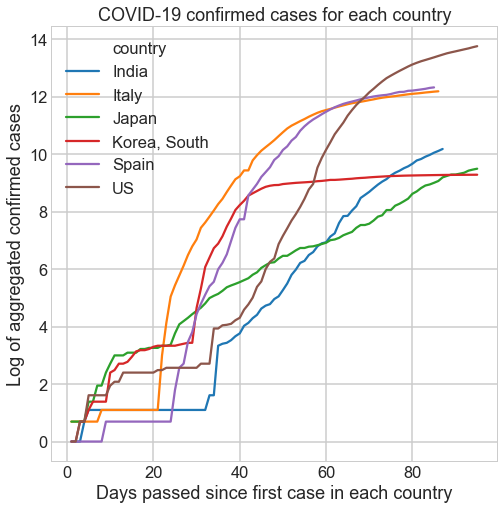

In [84]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small.days_after_1, y=onp.log(df_small.confirmed),
                  hue=df_small['country'])
ax.set(xlabel='Days passed since first case in each country',
       ylabel='Log of aggregated confirmed cases')
ax.set_title('COVID-19 confirmed cases for each country')
plt.show()

This graph shows the variation of log of  confirmed cases for various countries like India, Italy, US etc. We can see here that the confimed cases have seen an exponential increase with time. Almost all countries seem to show a similiar curve here. For all of them the initial 1 or 2 weeks seem to show a horizontal line which means that the cases here are not much(this could be attributed to less testing, less reporting or the incubation period where the person has caught the virus but is not sick yet) After these inital 2 to 3 weeks the rise seems to be alarming. Lets now see how the graph changes if we plot conformed cases directly instead of log of confirmed cases. 

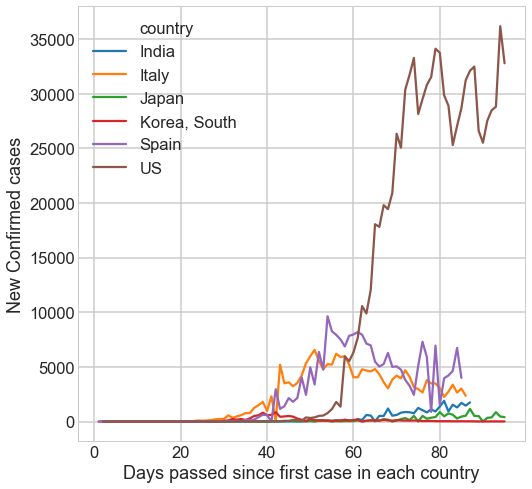

In [86]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small.days_after_1, y=df_small.new_confirmed,
                  hue=df_small['country'])
ax.set(xlabel='Days passed since first case in each country',
       ylabel='New Confirmed cases')
ax.set()
plt.show()

Here we can see that US surpasses every other country in terms of conformed cases. The graph for US was at nearly 0 for almost uptil 40 days signifying that the virus came in quite late to the US but once the cases started appearing, US seem to have done very pporly in terms of containing it for almost 4 weeks. This could be attributed to not advising stay at home and not closing non-essential businesses early on. After  

In [90]:
tidy_ddata = tidy_data(ddata, 'deaths')
df_small_death = tidy_ddata[tidy_ddata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea,South",
     "Japan", "India"])]

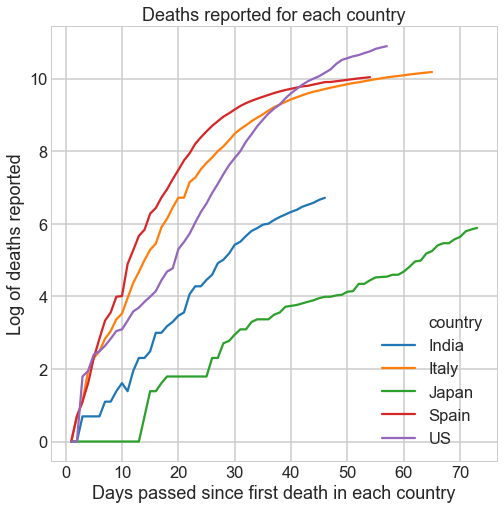

In [93]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small_death.days_after_1.values,
                  y=onp.log(df_small_death.deaths),
                  hue=df_small_death['country'])
ax.set(xlabel='Days passed since first death in each country',
       ylabel='Log of deaths reported')
plt.title("Deaths reported for each country")
plt.show()

We observe that the number of deaths reported for Italy, Spain and US since the day of the first confirmed death in each of the countries, is relatively higher compared the Asian countries namely Japan, India and South Korea. US has more number of deaths reported compared to Italy and Spain.

The tidy dataframe related to recoveries from COVID-19 is obtained and the data is subset for the countries such as Italy, US, Spain, Korea, South, Japan, India.

In [96]:
tidy_rdata = tidy_data(rdata, 'recovered')
df_small_recovered = tidy_rdata[tidy_rdata.country
                                .isin(['Italy', 'US',
                                       "Spain", "Korea, South",
                                       "Japan", "India"])]

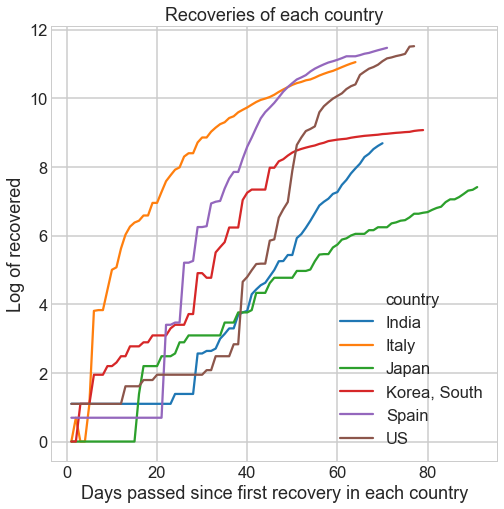

In [98]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small_recovered.days_after_1.values,
                  y=onp.log(df_small_recovered.recovered.values),
                  hue=df_small_recovered['country'])
ax.set(xlabel='Days passed since first recovery in each country',
       ylabel='Log of recovered')
plt.title("Recoveries of each country")
plt.show()

We observe that the number of recoveries from COVID-19 for Italy, Spain and US and it is because the number of confirmed cases of COVID-19 is relatively higher in those countries compared to the Asian countries.

## Data for the model

In [138]:
# Create a class to read and prepare the data in a numpy
# array with columns S, I, and R


class constructData():
    """
    Reads in data URLs and constructs the country's info in a numpy array
    """
    def __init__(self, url):
        self.url = url
        self.idata = pd.read_csv(url["confirmed"])
        self.ddata = pd.read_csv(url["deaths"])
        self.rdata = pd.read_csv(url["recovered"])

    def get_data(self, country, tot_pop):
        """
        Extract country's data from global data
        Aggregate recovered (alive) and deaths into R
        """
        Infected = self.construct_data(self.idata, country)
        R1 = self.construct_data(self.rdata, country)
        R2 = self.construct_data(self.ddata, country)
        Resistant = R1 + R2
        Infected = Infected - Resistant
        Susceptible = tot_pop - Infected - Resistant

        sir = onp.hstack([Susceptible, Infected, Resistant])
        return sir

    def construct_data(self, data, country):
        """
        Filter the country's data and put them in a numpy array
        """
        arr = data[data["Country/Region"] == country].iloc[0, :][4:]
        arr = arr.to_numpy()
        arr = arr.astype("float32")
        return arr.reshape(-1, 1)


### Country: The United States

In [118]:
US_tot_pop = get_country_pop("US")
data = constructData(url)
us = data.get_data("US", US_tot_pop)

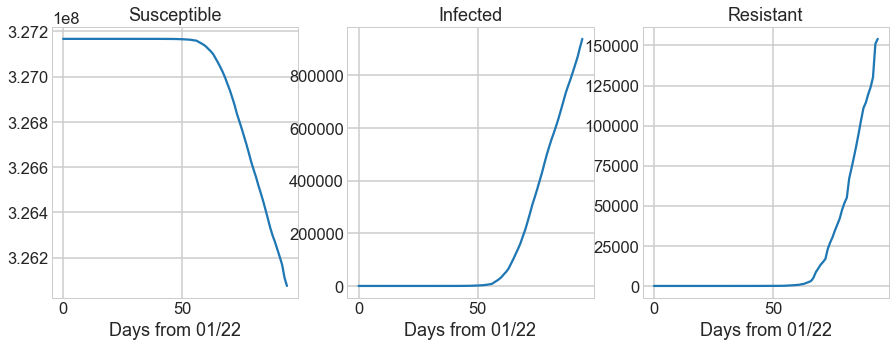

In [140]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(us[:, 0])
plt.xlabel("Days from 01/22")
plt.title("Susceptible")

plt.subplot(1, 3, 2)
plt.plot(us[:, 1])
plt.xlabel("Days from 01/22")
plt.title("Infected")

plt.subplot(1, 3, 3)
plt.plot(us[:, 2])
plt.xlabel("Days from 01/22")
plt.title("Resistant")

plt.show()

### ODE
Differential equations are used in SIR to show the change in each category per unit time. \\
Total population here is given by N. \\
N = S + I + R \\

The ODEs given in the image below were used in our SIR model. \\
beta  : Transmission rate \\
gamma : Recovery rate \\
delta : Rate at which beta changes 


![Image](../img/ODE.jpeg)

$$\texttt{Ordinary Differential Equations}$$

# Model Specification

In [127]:
def dz_dt(z, t, gamma, delta): 
    """
    Computes the change in one timestep according to ODEs
    z: components of the system that can vary through time (s, i, r, beta)
    t: timesteps
    gamma: the recovery rate (includes rates for both recovered (alive) and deaths)
    delta: the rate at which beta (the transmission rate) changes
    """
    s, i, r, beta = z
    N = s + i + r

    # ODEs
    ds_dt = -beta * (i/N) * s
    di_dt = beta * (i/N) * s - gamma * i 
    dr_dt = gamma * i
    dbeta_dt = -beta * delta

    return np.stack([ds_dt, di_dt, dr_dt, dbeta_dt])
    
    

In [129]:
# Function that integrates ODEs over time 
# takes as input the function where ODEs are defined
sir_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-3, mxstep=500)

In [151]:
def sir_model(M, y=None):
    """
    Main model: which defines priors for the parameters and
    initial populations, integrates the populations over time
    and samples
    M: number of datapoints
    y: datapoints in log scale (S-I-R populations in numpy array)
    """
    # define initial populations
    s_init = 3.2716733e+08
    i_init = 100
    r_init = 10

    # measurement times
    ts = np.arange(float(M))

    # parameters beta, gamma of dz_dt
    beta = numpyro.sample("beta", dist.TruncatedNormal(low=0.0,
                                                       loc=0.1,
                                                       scale=0.1))
    gamma = numpyro.sample("gamma", dist.TruncatedNormal(low=0.0,
                                                         loc=0.1,
                                                         scale=0.05))
    delta = numpyro.sample("delta", dist.TruncatedNormal(low=0.0,
                                                         loc=0.05,
                                                         scale=0.01))

    z_init = np.array([s_init, i_init, r_init, beta])

    # integrate dz/dt, z will have shape M x 4
    z = sir_int(z_init, ts, gamma, delta)

    # measurement errors
    sigma = numpyro.sample("sigma", dist.TruncatedCauchy(low=1e-10,
                                                         loc=np.array([0.5,
                                                                       0.5,
                                                                       0.5]),
                                                         scale=0.5))

    # measured populations (in log scale)
    numpyro.sample("y", dist.Normal(z[:, :-1], sigma), obs=y)

    return z, z_init

## Case: United States

* Now that we have the model ready, we initialize the populations and get the data ready. 
* We purposefully sliced the data for the US to consider from the date when the number of active infections reached 100. This is from date 03/03/2020. 
* The reason for such a slicing is that the exponential trend, which is our model's core assumption, could not be observed (due to measurement errors: not enough "accurate" reporting is done in the initial days of the infection spread). 

In [152]:
# Define initial populations for US
s_init = 3.2716733e+08
i_init = 100
r_init = 10
US_init_pop = (s_init, i_init, r_init)
_us = us[40:]

### Inference on the parameters

* We now infer on the parameters of the model given evidence. This is done as follows. 
    * The sir_model initializes the rates parameters and passes them onto build_odeint, which integrates the ODEs for each timestep. 
    * With mean as the output of above function, our predictions are sampled using a Gaussian distribution with sigma as std. 
    * The predictions are compared against the observations and the parameters are adjusted according to MCMC algorithm's optimization. 

In [154]:
# Arguments
num_warmup = 300
num_samples = 500
num_chains = 1

nuts_kernel = NUTS(sir_model)
mcmc = MCMC(nuts_kernel, num_warmup, num_samples,
            num_chains=num_chains)
mcmc.run(PRNGKey(2), M=_us.shape[0], y=_us)
mcmc.print_summary()

sample: 100%|██████████| 800/800 [00:28<00:00, 27.69it/s, 127 steps of size 2.01e-02. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.51      0.00      0.51      0.50      0.51    373.35      1.00
     delta      0.05      0.00      0.05      0.05      0.05    370.63      1.00
     gamma      0.01      0.00      0.01      0.01      0.01    457.40      1.00
  sigma[0]  12816.05   1202.21  12704.03  10741.68  14688.10    281.62      1.01
  sigma[1]  11400.24   1091.70  11393.41   9453.42  12866.92    307.59      1.00
  sigma[2]   2948.67    295.12   2918.90   2488.67   3374.18    361.96      1.00

Number of divergences: 0


### Plot results of Inference and prediction

* Following the inference on the parameters, we plot the predictions along with the evidence (data) to visualize how well the model has learned.

In [159]:
samples = mcmc.get_samples()

In [170]:
def sir_predict(timesteps, sample, y):
    """
    Computes the trajectories (s-i-r populations for all timesteps)
    of each initial parameter set (sample).
    timesteps: array of timesteps for which ODEs should be integrated
    sample: a MCMC inference sample consisting of one value for each parameter
    y: the evidence (data)
    """
    # compute trajectory using build_odeint function
    traj = handlers.substitute(sir_model, sample)(len(y), y)
    z, z_init = traj

    # sigma: the std for our prediction is broadcast with this formula
    # sigma(t) = base_sigma * sqrt(timestep)
    sigma = sample["sigma"]
    timesteps = (timesteps+1).reshape(-1, 1)
    sigma = sigma.reshape(1, -1)
    _sigma = np.sqrt(timesteps).dot(sigma)
    pred = numpyro.sample("pred", dist.Normal(loc=z[:, :-1], scale=_sigma))
    beta_traj = numpyro.sample("beta_traj", dist.Delta(z[:, -1]))
    return pred, z[:, -1]


def predict(timesteps, rng_key, sample, y):
    """
    Computes prediction and beta trajectories using model trace
    """
    sir_predict_model = handlers.seed(sir_predict, rng_seed=rng_key)
    predict_trace = handlers.trace(sir_predict_model).get_trace(timesteps,
                                                                sample,
                                                                y)
    res = predict_trace["pred"]["value"]
    beta_traj = predict_trace["beta_traj"]["value"]
    return res, beta_traj

20:5: F841 local variable 'beta_traj' is assigned to but never used
INFO:pycodestyle:20:5: F841 local variable 'beta_traj' is assigned to but never used


In [171]:
# Vectorize trajectory computations using vmap
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_pred = vmap(lambda rng_key,
                   sample: predict(np.arange(len(_us)),
                                   rng_key, sample, _us))(rng_keys, samples)
result_pred, beta_traj = result_pred
mu, pi = np.mean(result_pred, 0), np.percentile(result_pred, (10, 90), 0)

#### Plot the results of the prediction

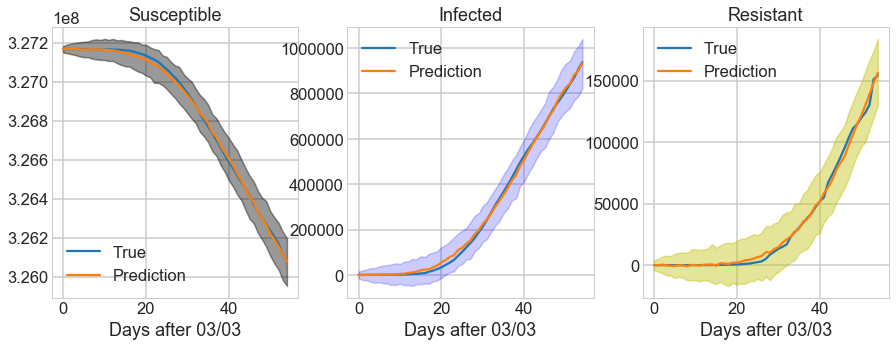

In [172]:
days = np.arange(_us.shape[0])

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(days, _us[:, 0], label="True")
plt.plot(days, mu[:, 0], label="Prediction")
plt.fill_between(days, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Susceptible")

plt.subplot(1, 3, 2)
plt.plot(_us[:, 1], label="True")
plt.plot(mu[:, 1], label="Prediction")
plt.fill_between(days, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.2)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Infected")

plt.subplot(1, 3, 3)
plt.plot(_us[:, 2], label="True")
plt.plot(mu[:, 2], label="Prediction")
plt.fill_between(days, pi[0, :, 2], pi[1, :, 2], color="y", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.title("Resistant")
plt.legend()
plt.show()

* The above plots show in blue the data for S-I-R categories and the model's prediction as the band (trajectories based on parameters of mcmc samples). The mean of the band is showin in orange. 
* The mean trajectory follows closely the data which is encouraging. 
* This allows us to reasonably forecast what the future would look like for the number of populations if no external agent intervenes.

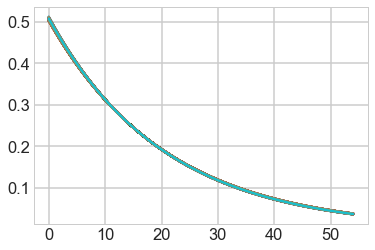

In [173]:
plt.plot(beta_traj.T)
plt.show()

* The plots show the predictions of 3 populations (predicted using parameters sampled from posterior distributions given evidence - data)
* The uncertainity band for susceptible case is quite tight because of the scale.

#### Forecasting and Interventions

* Now that we have the model ready with posterior distributions of the parameters, we can let the model figure out the population numbers as long as no external factors intervene (such as enforcing a new policy restricting/ isolating infected population or more stricter social distancing as is/ was common in certain countries.

In [197]:
def forecast_sir(future_timesteps, sample, y, int_delta=None):
    """
    Computes z (s-i-r-beta) for future_timesteps taking the parameters
    from sample (one output of mcmc)
    future_timesteps: number of timesteps for which forecasting is sought
    sample: one unit (parameters from pos. dist. from mcmc samples)
    z_init: initial populations just prior to forcasting timestep
    (array of s-i-r-beta)
    """
    sigma = sample["sigma"]

    traj = handlers.substitute(sir_model, sample)(len(y), y)
    pred = numpyro.sample("pred", dist.Normal(loc=traj[0][:, :-1],
                                              scale=sigma))

    fcast_z_init = np.array([*pred[-1, :], traj[0][-1, -1]])

    if not int_delta:
        new_z = sir_int(fcast_z_init, future_timesteps,
                        sample["gamma"], sample["delta"])
    else:
        new_z = sir_int(fcast_z_init, future_timesteps,
                        sample["gamma"], int_delta)

    future_timesteps = (future_timesteps+1).reshape(-1, 1)
    sigma = sigma.reshape(1, -1)
    _sigma = np.sqrt(future_timesteps).dot(sigma)

    fcast = numpyro.sample("fcast", dist.Normal(new_z[:, :-1], _sigma))
    return pred, fcast


def forecast(future_timesteps, rng_key, sample, y, int_delta=None):
    """
    Forecast s-i-r-beta populations for future timesteps given a sample
    and evidencewith option for intervention on transmission
    rate (beta) change.
    """
    forecast_sir_model = handlers.seed(forecast_sir, rng_seed=rng_key)
    fcast_trce = handlers.trace(forecast_sir_model).get_trace(future_timesteps,
                                                              sample, y,
                                                              int_delta)
    pred_z = fcast_trce["pred"]["value"]
    fcast_z = fcast_trce["fcast"]["value"]
    return (pred_z, fcast_z)

In [214]:
def plot_forecast(result):
    result_pred, result_forecast = result
    mu, pi = np.mean(result_pred, 0), np.percentile(result_pred, (10, 90), 0)
    percentile = np.percentile(result_forecast[:, 1:], (10, 90), 0)
    new_mu, new_pi = np.mean(result_forecast[:, 1:], 0), percentile

    days = np.arange(len(_us) + 90)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(days[:len(_us)], _us[:, 0], label="True")
    plt.plot(days[:len(_us)], mu[:, 0], label="Prediction")
    plt.fill_between(days[:len(_us)],
                     pi[0, :, 0],
                     pi[1, :, 0],
                     color="k",
                     alpha=0.4)

    plt.plot(days[len(_us):], new_mu[:, 0], label="Forecast")
    plt.fill_between(days[len(_us):],
                     new_pi[0, :, 0],
                     new_pi[1, :, 0],
                     color="k",
                     alpha=0.4)
    plt.xlabel("Days after 03/03")
    plt.legend()
    plt.title("Susceptible")

    plt.subplot(1, 3, 2)
    plt.plot(days[:len(_us)], _us[:, 1], label="True")
    plt.plot(days[:len(_us)], mu[:, 1], label="Prediction")
    plt.fill_between(days[:len(_us)],
                     pi[0, :, 1],
                     pi[1, :, 1],
                     color="b",
                     alpha=0.2)
    plt.plot(days[len(_us):],
             new_mu[:, 1],
             label="Forecast")
    plt.fill_between(days[len(_us):],
                     new_pi[0, :,1],
                     new_pi[1, :, 1],
                     color="k",
                     alpha=0.4)
    plt.xlabel("Days after 03/03")
    plt.legend()
    plt.title("Infected")

    plt.subplot(1, 3, 3)
    plt.plot(days[:len(_us)], _us[:, 2], label="True")
    plt.plot(days[:len(_us)], mu[:, 2], label="Prediction")
    plt.fill_between(days[:len(_us)],
                     pi[0, :, 2],
                     pi[1, :, 2],
                     color="y",
                     alpha=0.4)
    plt.plot(days[len(_us):], new_mu[:, 2], label="Forecast")
    plt.fill_between(days[len(_us):],
                     new_pi[0, :, 2],
                     new_pi[1, :, 2],
                     color="k",
                     alpha=0.4)
    plt.xlabel("Days after 03/03")
    plt.title("Resistant")
    plt.legend()
    plt.show()

In [218]:
# Forecast for next 90 days
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_forecast = vmap(lambda rng_key,
                       sample: forecast(np.arange(float(91)),
                                        rng_key, sample, _us))(rng_keys, samples)

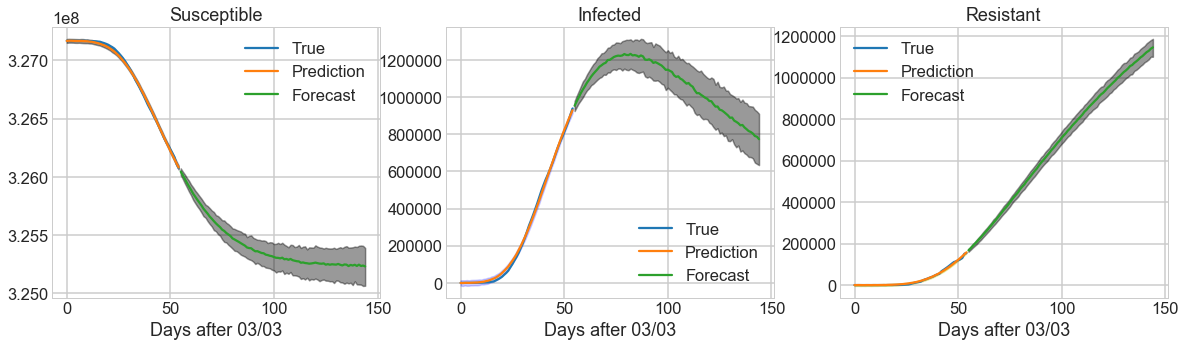

In [219]:
plot_forecast(result_forecast)

* The above plots show our forecasts for S-I-R populations. The gray band is the uncertainity band whose width increases with time to realize our uncertainity in the trajectory. 
* The model forecasts, by day ~67, the daily confirmed cases will begin to see a drop (an encouraging thought). However, this is highly conditional on our assumption on the ever decreasing transmission rate (beta) which may not be too realistic in the later part of the pandemic. 

### Intervention on Delta (the rate of decay of transmission rate)

* We set delta (the rate at which beta decays) deterministically to 0.1 (\~2x of observed rate) and 1(\~20x of observed rate). 
* Delta = 1. is the largest value that delta can have because with delta = 1: in the next time step beta becomes zero. 

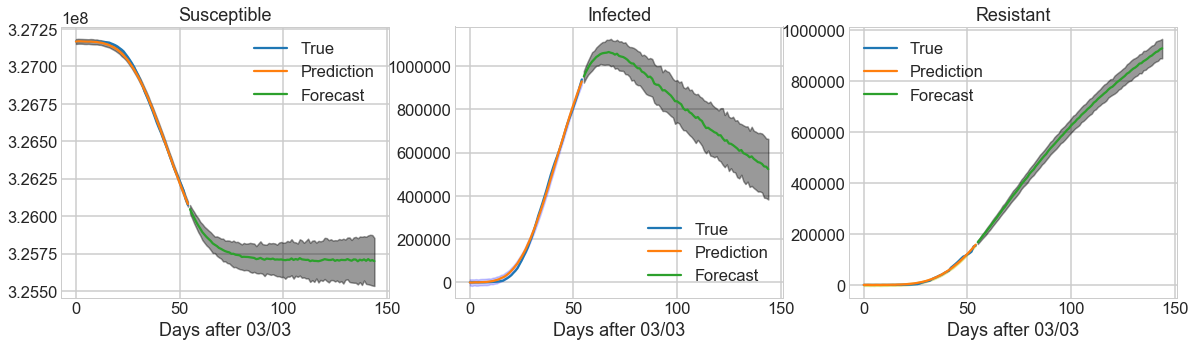

In [225]:
# Forecast for next 90 days but with delta = 0.1
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_forecast_int1 = vmap(lambda rng_key,
                            sample: forecast(np.arange(float(91)),
                                             rng_key, sample,
                                             _us, 0.1))(rng_keys, samples)

plot_forecast(result_forecast_int1)

* The above graph shows S-I-R populations when delta is set at 0.1 deterministically at present time. We then let the model forecast for the next 90 days. 
* In contrast with the original forecast with no interventions, the number of active infected cases will be less in this case. 

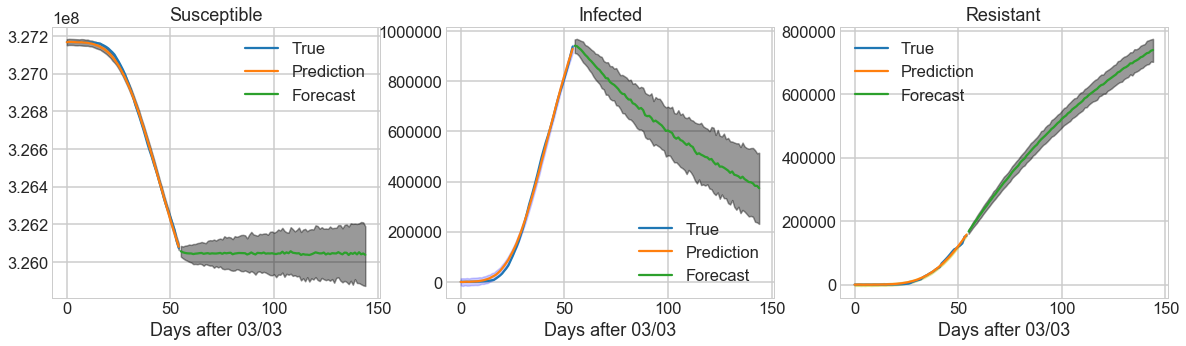

In [229]:
# Forecast for next 90 days but with delta = 1
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_forecast_int2 = vmap(lambda rng_key,
                            sample: forecast(np.arange(float(91)),
                                             rng_key, sample,
                                             _us, 1))(rng_keys, samples)

plot_forecast(result_forecast_int2)

* The above graph shows S-I-R populations when delta=1. This is more of a sanity check on the model. Since we know delta=1.0 implies that in the next time step beta becomes 0. That means there should be no additional infections. So the susceptible population goes constant. The number of infected cases will immediately see a decrease because some of the infected population become resistant. 

# Counterfactuals

#### How would the forecast look like had we practiced stricter control measures (w.r.t. social distancing or isolation of infected population or such policies)?

* This is a counterfactual quesiton. 
* Observation (or evidence) is the current forecast.

* To do this, we will need to figure out the initial parameters that led to current forecast.
* This is already done. Current forecast is the extension of the trajectories given the S-I-R data. 
* The initial parameters can be sampled from posteriors computed by the MCMC inference algo. 
* Now we simulate the forecast with only one change: delta := 0.075 

In [241]:
def cf_forecast_sir(future_timesteps, sample, y, int_delta=None):
    """
    Computes z (s-i-r-beta) for future_timesteps taking the parameters
    from sample (one output of mcmc)
    future_timesteps: number of timesteps for which forecasting is sought
    sample: one unit (parameters from pos. dist. from mcmc samples)
    z_init: initial populations just prior to forcasting timestep
    (array of s-i-r-beta)
    """
    sigma = sample["sigma"]
    sample["delta"] = int_delta

    timesteps = np.arange(0.0, len(y)+len(future_timesteps))
    sigma = sigma.reshape(1, -1)
    _sigma1 = np.sqrt((timesteps+1).reshape(-1, 1)).dot(sigma)

    traj = handlers.substitute(sir_model, sample)(len(y), y)
    # pred = numpyro.sample("pred",
    #            dist.Normal(loc=traj[0][:, :-1], scale=_sigma1))
    # fcast_z_init = np.array([*pred[-1, :],
    #           traj[0][-1, -1]])

    fcast_z_init = traj[1]
    future_timesteps = timesteps

    if not int_delta:
        new_z = sir_int(fcast_z_init,
                        future_timesteps,
                        sample["gamma"],
                        sample["delta"])
    else:
        new_z = sir_int(fcast_z_init,
                        future_timesteps,
                        sample["gamma"],
                        int_delta)

    # future_timesteps = (future_timesteps+len(y)).reshape(-1, 1)
    # sigma = sigma.reshape(1, -1)
    # _sigma = np.sqrt(future_timesteps).dot(sigma)

    fcast = numpyro.sample("fcast", dist.Normal(new_z[:, :-1], _sigma1))
    return fcast


def cf_forecast(future_timesteps, rng_key, sample, y, int_delta=None):
    """
    Forecast s-i-r-beta populations for future timesteps
    given a sample and evidencewith option for intervention
    on transmission rate (beta) change.
    """
    forecast_sir_model = handlers.seed(cf_forecast_sir,
                                       rng_seed=rng_key)
    fcast_trce = handlers.trace(forecast_sir_model).get_trace(future_timesteps,
                                                              sample, y,
                                                              int_delta)
    # pred_z = forecast_trace["pred"]["value"]
    pred_z = 0.0
    fcast_z = fcast_trce["fcast"]["value"]
    fcast_z = np.clip(fcast_z, 0.0)
    return (pred_z, fcast_z)

The computation of the forecast, and plots are very similar to interventions.

In [243]:
# Forecast for next 90 days
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_forecast = vmap(lambda rng_key,
                       sample: cf_forecast(np.arange(float(91)),
                                           rng_key, sample, _us,
                                           int_delta=0.075))(rng_keys, samples)

In [244]:
mu, pi = np.mean(result_forecast[1], 0), np.percentile(result_forecast[1], (10, 90), 0)

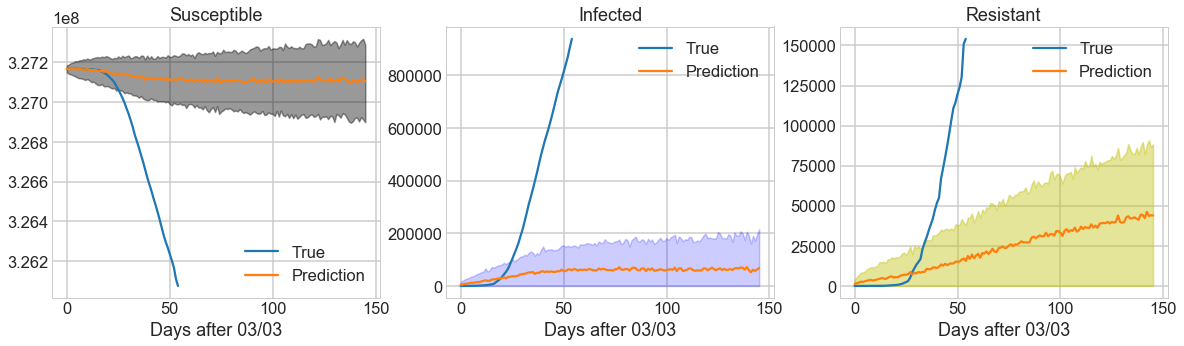

In [247]:
days = np.arange(result_forecast[1].shape[1])
idays = len(_us)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(days[:idays], _us[:, 0], label="True")
plt.plot(days, mu[:, 0], label="Prediction")
plt.fill_between(days, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Susceptible")

plt.subplot(1, 3, 2)
plt.plot(_us[:, 1], label="True")
plt.plot(mu[:, 1], label="Prediction")
plt.fill_between(days, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.2)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Infected")

plt.subplot(1, 3, 3)
plt.plot(_us[:, 2], label="True")
plt.plot(mu[:, 2], label="Prediction")
plt.fill_between(days, pi[0, :, 2], pi[1, :, 2], color="y", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.title("Resistant")
plt.legend()
plt.show()

* The above plots show how the US's S-I-R population varies if delta is 0.075 (~1.5x the original, unchanged rate). 
* The active infected population would not exceed 100k (mean only) which is orders of magnitude less than the current estimates of the forecast. 

#### How would the forecast look like had we NOT practiced any control measures (w.r.t. social distancing or isolation of infected population or such policies)?

* This is an extreme case of a hypothetical scenario of when the US carries on as it would if there were no pandemic. 
* We adjust delta to 0.0

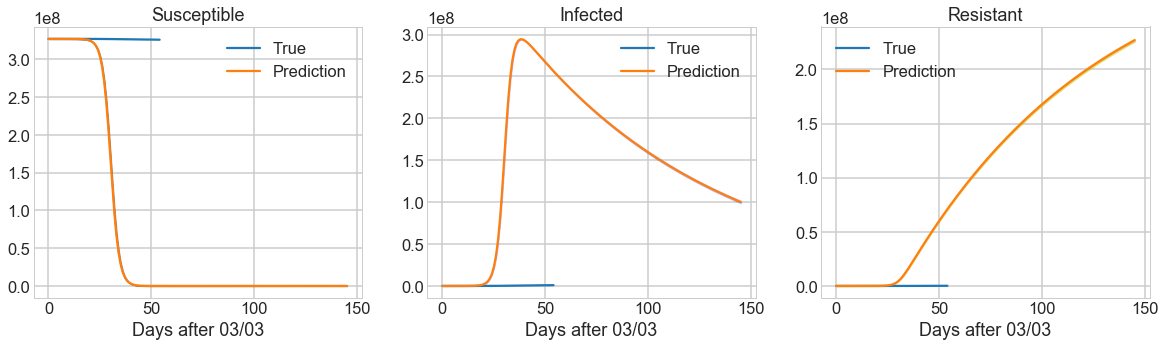

In [251]:
# Forecast for next 90 days
rng_keys = random.split(random.PRNGKey(3), samples["beta"].shape[0])
result_forecast = vmap(lambda rng_key,
                       sample: cf_forecast(np.arange(float(91)),
                                           rng_key, sample,
                                           _us,
                                           int_delta=0.0))(rng_keys, samples)
perc = np.percentile(result_forecast[1], (10, 90), 0)
mu, pi = np.mean(result_forecast[1], 0), perc

days = np.arange(result_forecast[1].shape[1])
idays = len(_us)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(days[:idays], _us[:, 0], label="True")
plt.plot(days, mu[:, 0], label="Prediction")
plt.fill_between(days, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Susceptible")

plt.subplot(1, 3, 2)
plt.plot(_us[:, 1], label="True")
plt.plot(mu[:, 1], label="Prediction")
plt.fill_between(days, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.2)
plt.xlabel("Days after 03/03")
plt.legend()
plt.title("Infected")

plt.subplot(1, 3, 3)
plt.plot(_us[:, 2], label="True")
plt.plot(mu[:, 2], label="Prediction")
plt.fill_between(days, pi[0, :, 2], pi[1, :, 2], color="y", alpha=0.4)
plt.xlabel("Days after 03/03")
plt.title("Resistant")
plt.legend()
plt.show()

* The above plot shows the S-I-R populations for when delta=0.0
* It turns out the whole population is infected (which is obvious and to be expected). 
* What is remarkable is that, the active infected cases would reach ~300 million very quickly. 

* Of course, this is very unlikely on two accounts 
    * The pandemic cannot sustain such a high rate of active infections for a sustained period of time. 
    * The number of recoveries would not be that high.